# TP 2 : Classification non supervisée de textures

## Auteurs :
- BURGER Loan
- PETIT Lucas

## Date :
- 13/11/2023

## Done :
Découper les images en patchs

Faire l'histogramme des gradient sur toute nos données (gradient en noir et blanc)
   - Sobel en x et y sur le gradient
   - Tableaau de n valeurs pour les orientations
   - Pour chaque pixels la valeur est donnée par arc tan (y/x)

## TODO :
Labeliser nos données (faire des tuples <np_array, num_image> ?)

Entrainer notre k_means avec les données de train
Pour chaque cluster determiner le label dominant
Classifier nos données de tests avec k_means et vérifier si les prédictions sont corrects

Générer des textures et les classifier avec k_means

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

## Implémentation des algorithmes

In [2]:
def k_means(data, k, max_iterations):
    cluster_centers = []
    clusters = []
    iterations = 0

    for i in range(k):
        cluster_centers.append(data[i])

    for i in range(k):
        clusters.append([])

    for i in range(len(data)):
        distances = []
        for j in range(k):
            distances.append(np.linalg.norm(data[i] - cluster_centers[j]))
        clusters[distances.index(min(distances))].append(data[i])

    for i in range(k):
        cluster_centers[i] = np.mean(clusters[i], axis=0)

    while True and iterations < max_iterations:
        changed = False
        for i in range(len(data)):
            distances = []
            for j in range(k):
                distances.append(np.linalg.norm(data[i] - cluster_centers[j]))
            clusters[distances.index(min(distances))].append(data[i])

        for i in range(k):
            if not np.array_equal(cluster_centers[i], np.mean(clusters[i], axis=0)):
                changed = True
            cluster_centers[i] = np.mean(clusters[i], axis=0)

        if not changed:
            break

        iterations += 1

    return cluster_centers, clusters

In [31]:
def predict(data, cluster_centers):
    predictions = []
    for i in range(len(data)):
        distances = []
        for j in range(len(cluster_centers)):
            distances.append(np.linalg.norm(data[i] - cluster_centers[j]))
        predictions.append(distances.index(min(distances)))

    return predictions

In [3]:
def train_test(filenames, patch_size):
    train_data = []
    test_data = []
    for i in range(len(filenames)):
        img_data = []
        sample_image = Image.open(filenames[i])
        sample_image_gray = sample_image.convert('L')
        np_sample_img = np.array(sample_image_gray)
        for x in range(0, np_sample_img.shape[0], patch_size):
            for y in range(0, np_sample_img.shape[1], patch_size):
                patch = np_sample_img[x:x + patch_size, y:y + patch_size]
                img_data.append(patch)

        random.shuffle(img_data)
        half = int(len(img_data) / 2)
        train_data.append(img_data[:half])
        test_data.append(img_data[half:])

    return train_data, test_data

In [4]:
def gradient(img):
    img = np.array(img)
    img = img.astype('int32')
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    gradient_x = np.zeros((img.shape[0], img.shape[1]))
    gradient_y = np.zeros((img.shape[0], img.shape[1]))

    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            gradient_x[i][j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * sobel_x)
            gradient_y[i][j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * sobel_y)

    return gradient_x, gradient_y

In [5]:
def HOG(img, n_bins):
    gradient_x, gradient_y = gradient(img)
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)
    gradient_orientation = np.rad2deg(gradient_orientation)
    gradient_orientation[gradient_orientation < 0] += 180

    bins = np.linspace(0, 180, n_bins + 1)
    bins = bins.astype('int32')

    histogram = np.zeros(n_bins)

    for i in range(gradient_orientation.shape[0]):
        for j in range(gradient_orientation.shape[1]):
            for k in range(n_bins):
                if bins[k] <= gradient_orientation[i][j] < bins[k + 1]:
                    histogram[k] += gradient_magnitude[i][j]

    return histogram

  ## Classification des données 2D (GMM2D) en 5 classes

/tmp/ipykernel_6698/2761471185.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


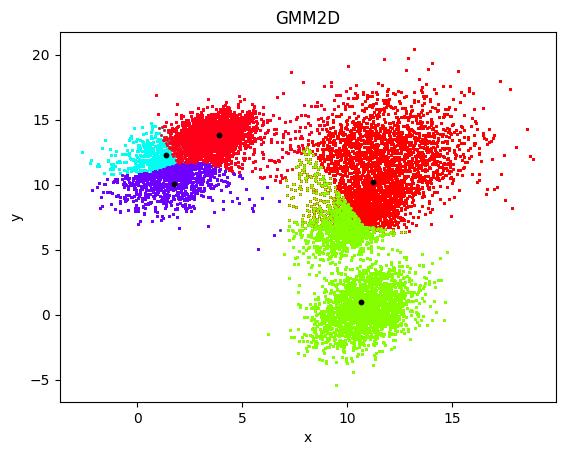

In [6]:
gmm2d = np.loadtxt("classif_data/gmm2d.asc")
centers, clusters = k_means(gmm2d, 5, 100)
cmap = get_cmap(len(clusters))

fig = plt.figure()
plt.title("GMM2D")
plt.xlabel("x")
plt.ylabel("y")
for i in range(len(clusters)):
    x = []
    y = []
    for j in range(len(clusters[i])):
        x.append(clusters[i][j][0])
        y.append(clusters[i][j][1])
    plt.scatter(x, y, s=1, color=cmap(i))

for i in range(len(centers)):
    plt.scatter(centers[i][0], centers[i][1], color='black', s=10)
plt.show()

fig.savefig("GMM2D_K-Means_k5.png")

  ## Classification des données 3D (GMM3D) en 5 classes

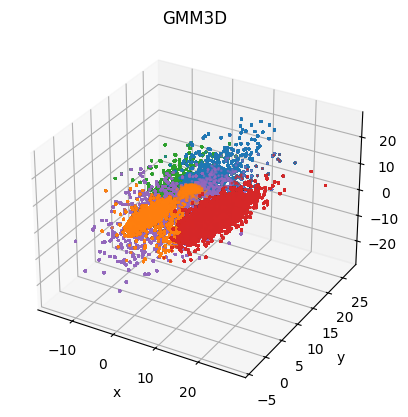

In [7]:
# Kmean GMM3D
gmm3d = np.loadtxt("classif_data/gmm3d.asc")
centers, clusters = k_means(gmm3d, 5, 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("GMM3D")
plt.xlabel("x")
plt.ylabel("y")
for i in range(len(clusters)):
    x = []
    y = []
    z = []
    for j in range(len(clusters[i])):
        x.append(clusters[i][j][0])
        y.append(clusters[i][j][1])
        z.append(clusters[i][j][2])
    ax.scatter(x, y, z, s=1)
plt.show()
fig.savefig("GMM3D_K-Means_k5.png")

## Découpages des images en patches (sans recouvrement)
Les l'ensemble des patchs et divisé en 2 pour optimiser la classification (train_data) et l’autre comme ensemble de test (test_data)

In [23]:
filenames = ["Colored_Brodatz/D1_COLORED.tif",
             "Colored_Brodatz/D2_COLORED.tif",
             "Colored_Brodatz/D3_COLORED.tif",
             "Colored_Brodatz/D4_COLORED.tif",
             "Colored_Brodatz/D5_COLORED.tif"]

train_data, test_data = train_test(filenames, 64)

## Sauvegarde des patches (optionnel)

In [24]:
for i in range(len(train_data[0])):
    patch_img = Image.fromarray(train_data[0][i])
    patch_img.save("Patches/train{}_size32.png".format(i))

for i in range(len(test_data[0])):
    patch_img = Image.fromarray(test_data[0][i])
    patch_img.save("Patches/test{}_size32.png".format(i))

## Histogramme de gradients d'un patch (optionnel)

[59456.66862814 17623.96229824 11571.67133411  9340.55004547
 13693.94141794 80031.91478378 18675.36821898  8899.11177709
 10874.22193726 12530.74484952 30750.28723156]


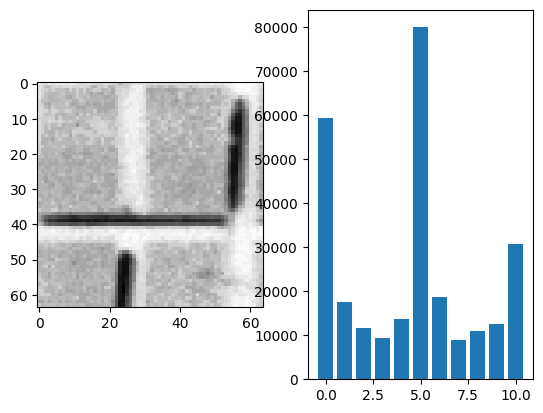

In [25]:
img = Image.fromarray(train_data[0][0])
img_gray = img.convert('L')
histogram = HOG(img_gray, 11)
print(histogram)

#print image and histogram
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(img_gray, cmap='gray')
ax = fig.add_subplot(1,2,2)
ax.bar(np.arange(11), histogram)
plt.show()

## Calcul des histogrammes de gradients

In [35]:
histograms = []
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        img = Image.fromarray(train_data[i][j])
        img_gray = img.convert('L')
        histogram = HOG(img_gray, 11)
        histograms.append(histogram)

## Classification des données de test avec les histogrammes de gradients

/tmp/ipykernel_6698/2761471185.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


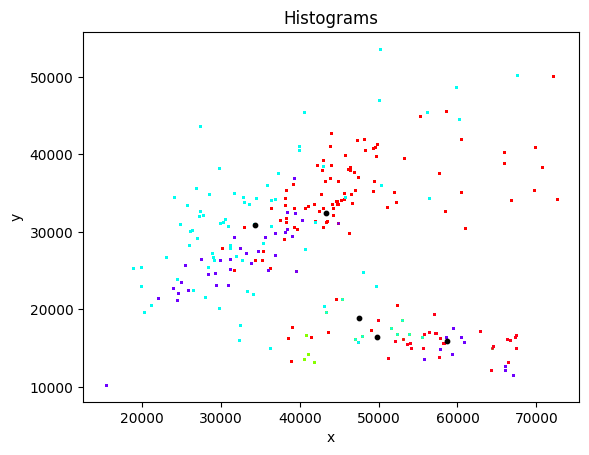

In [28]:
centers, clusters = k_means(histograms, 5, 100)
cmap = get_cmap(len(clusters))

fig = plt.figure()
plt.title("Histograms")
plt.xlabel("x")
plt.ylabel("y")
for i in range(len(clusters)):
    x = []
    y = []
    for j in range(len(clusters[i])):
        x.append(clusters[i][j][0])
        y.append(clusters[i][j][1])
    plt.scatter(x, y, s=1, color=cmap(i))
    
for i in range(len(centers)):
    plt.scatter(centers[i][0], centers[i][1], color='black', s=10)
plt.show()

## Test du classifieur avec les données de train

In [34]:
predictions = predict(histograms, centers)
print(predictions)

[2, 0, 4, 0, 4, 0, 0, 0, 2, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 2, 2, 4, 0, 2, 0, 0, 2, 0, 2, 2, 4, 0, 0, 0, 4, 0, 4, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Génération de textures et classification